Copyright (C) 2023, Zhao Bingqiang, All Rights Reserved

Email: zbqherb@163.com

2023-05-23

# Import Libs

In [1]:
import os
import cv2
import math
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

## Creat directory

In [11]:
if not os.path.exists('figure'):
    os.makedirs('figure')
if not os.path.exists('table'):
    os.makedirs('table')
if not os.path.exists('checkpoint'):
    os.makedirs('checkpoint')

## Image Data Exploratory Analysis

### Image Size Distribution

In [20]:
dataset_path = 'data'
os.chdir(dataset_path)
os.listdir()

['CAP', 'COVID', 'NonCOVID']

In [21]:
df = pd.DataFrame()

for image in tqdm(os.listdir()): # scanning each class   
    os.chdir(image)
    for file in os.listdir(): # scanning each image
        try:
            img = cv2.imread(file)
            df = df.append({'Class':image, 'File_Name':file, 'Width':img.shape[1], 'Height':img.shape[0]}, ignore_index=True)
        except:
            print(os.path.join(image, file), 'Read Error')
    os.chdir('../')
os.chdir('../')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:32<00:00, 30.85s/it]


In [22]:
df

,Class,File_Name,Width,Height
0,CAP,cap006_10.png,512,512
1,CAP,cap006_11.png,512,512
2,CAP,cap006_12.png,512,512
3,CAP,cap006_14.png,512,512
4,CAP,cap006_15.png,512,512
...,...,...,...,...
17096,NonCOVID,normal038_181.png,512,512
17097,NonCOVID,normal038_183.png,512,512
17098,NonCOVID,normal038_185.png,512,512
17099,NonCOVID,normal038_4.png,512,512


### Visualize Image Size Distribution

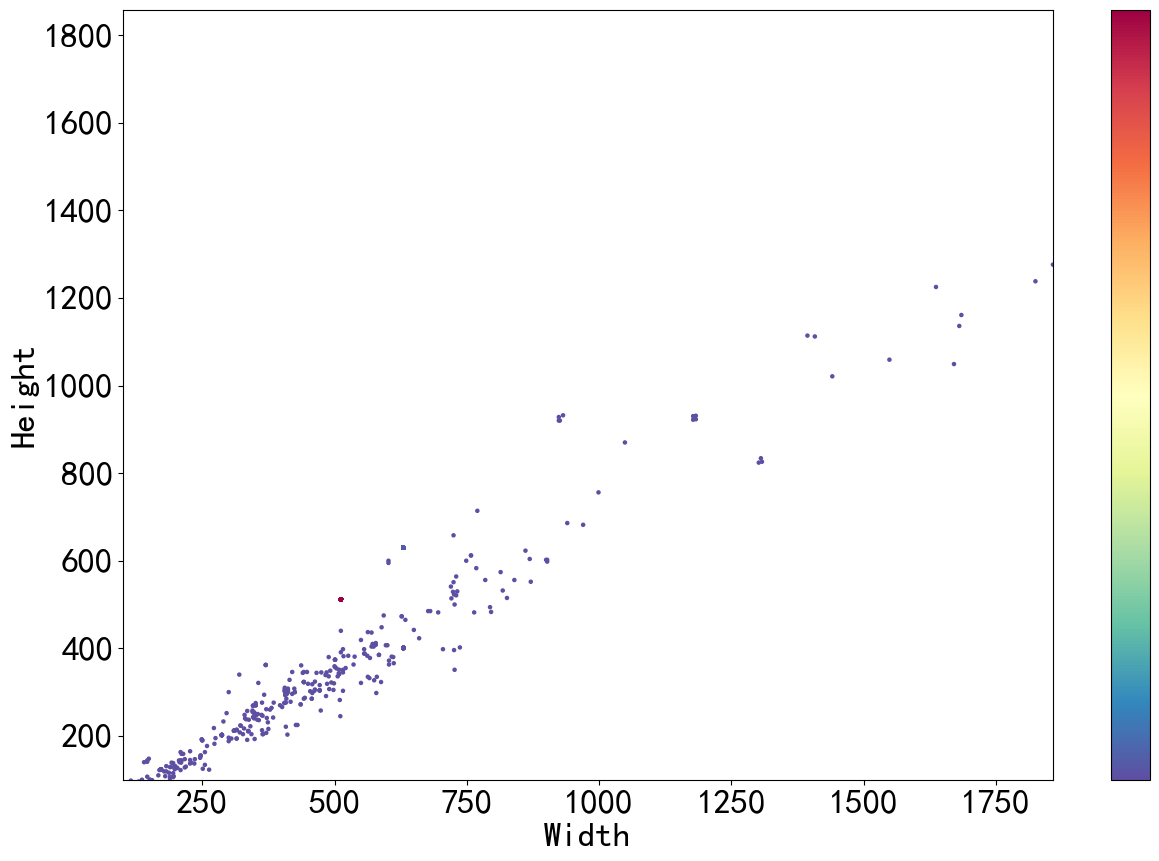

In [23]:
x = df['Width']
y = df['Height']

xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize = (15,10))
plt.scatter(x, y, c = z,  s = 5, cmap = 'Spectral_r')
plt.colorbar(ticks = [])
plt.tick_params(labelsize = 25)
xy_max = max(max(df['Width']), max(df['Height']))
plt.xlim(xmin = 100, xmax = xy_max)
plt.ylim(ymin = 100, ymax = xy_max)

plt.ylabel('Height', fontsize = 25)
plt.xlabel('Width', fontsize = 25)

plt.savefig('figure/Image_Size_Distribution.tif', dpi = 300, bbox_inches = 'tight')

## Dataset Split

###  Create `train_dataset` and `test_dataset`

In [24]:
classes = os.listdir(dataset_path)

# new train directory
os.mkdir(os.path.join(dataset_path, 'train'))
# new test directory
os.mkdir(os.path.join(dataset_path, 'val'))

# new each class directory in the train and test directory
for image in classes:
    os.mkdir(os.path.join(dataset_path, 'train', image))
    os.mkdir(os.path.join(dataset_path, 'val', image))

### Split `train_dataset` and `test_dataset` while move image file

We split the fine-tuning dataset into train and validation sets. We randomly sample 20% of the dataset to used as a validation set.

In [25]:
dataset_name = dataset_path.split('_')[0]

test_frac = 0.2  # test_dataset ratio

random.seed(123) 

df = pd.DataFrame()

print('{:^18} {:^18} {:^18}'.format('Class', 'train_dataset number', 'test_dataset number'))

for image in classes: # scanning each class

    # Read all image file names for this class
    old_dir = os.path.join(dataset_path, image)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename) # Shuffle at random

    # Split tarin_dataset and test_dataset
    testset_numer = int(len(images_filename) * test_frac) # test_dataset image number
    testset_images = images_filename[:testset_numer]      # Gets the file name of the test set image will be move to the test_dataset directory
    trainset_images = images_filename[testset_numer:]     # Gets the file name of the train set image will be move to the train_dataset directory

    # Move image to test directory
    for images in testset_images:
        old_img_path = os.path.join(dataset_path, image, images)         # Gets the original file path
        new_test_path = os.path.join(dataset_path, 'val', image, images) # Gets the new file path of the test_dataset directory
        shutil.move(old_img_path, new_test_path) # move file

    # Move image to train directory
    for images in trainset_images:
        old_img_path = os.path.join(dataset_path, image, images)           # Gets the original file path
        new_train_path = os.path.join(dataset_path, 'train', image, images) # Gets the new file path of the train_dataset directory
        shutil.move(old_img_path, new_train_path) # move file
    
    # Delete old image directory
    assert len(os.listdir(old_dir)) == 0 # Make sure all the images in the old directory were moved away
    shutil.rmtree(old_dir) # Delete directory
    
    # Output the number of data for each class
    print('{:^18} {:^18} {:^18}'.format(image, len(trainset_images), len(testset_images)))
    
    # Save to the table
    df = df._append({'class':image, 'trainset':len(trainset_images), 'testset':len(testset_images)}, ignore_index=True)

# Rename the data set directory
shutil.move(dataset_path, dataset_name+'_split')

# The quantity statistics table of each category of data set is exported as a csv file
df['total'] = df['trainset'] + df['testset']
df.to_csv('table/Image quantity statistics.csv', index = False)

      Class        train_dataset number test_dataset number
       CAP                2095               523        
      COVID               6072               1518       
     NonCOVID             5515               1378       


In [26]:
df

,class,trainset,testset,total
0,CAP,2095,523,2618
1,COVID,6072,1518,7590
2,NonCOVID,5515,1378,6893


### File directory structure

In [27]:
!tree data_split

卷 软件 的文件夹 PATH 列表
卷序列号为 0C93-F210
D:\PYTHON PROJECT\工作3 MEDICAL IMAGE CLASSIFICATION\LARGE COVID-19 CT SCAN SLICE DATASET\RESNET18\DATA_SPLIT
├─train
│  ├─CAP
│  ├─COVID
│  └─NonCOVID
└─val
    ├─CAP
    ├─COVID
    └─NonCOVID


# Visualize Raw Images

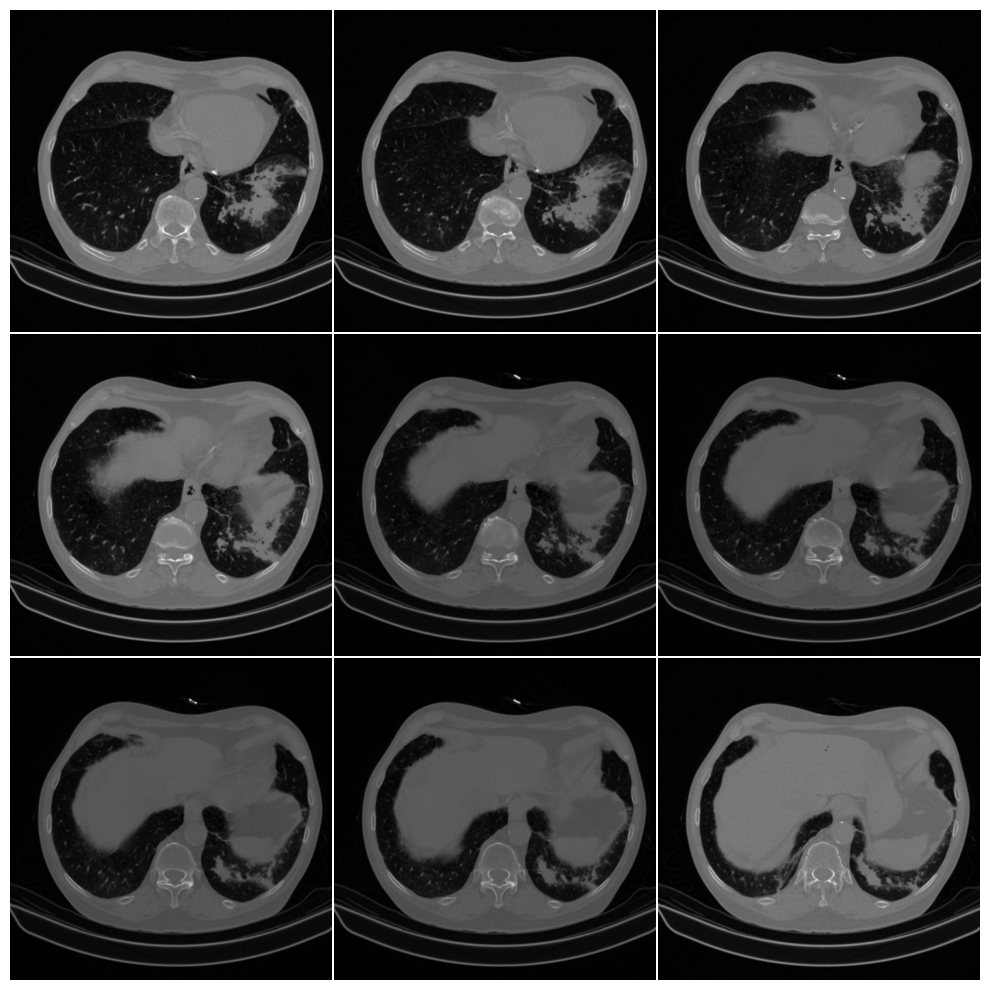

In [4]:
# Specify the directory where you want to visualize the image
folder_path = 'data_split/train/CAP'
N = 9   # The number of visualized images
n = math.floor(np.sqrt(N))
# read all the images in the directory
images = []
for each_img in os.listdir(folder_path)[:N]:
    img_path = os.path.join(folder_path, each_img)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    images.append(img_rgb)

# show the images
fig = plt.figure(figsize = (10, 10))
grid = ImageGrid(fig, 111,  
                 nrows_ncols = (n, n),  
                 axes_pad = 0.02,  
                 share_all = True
                 )
## Scanning each image
for ax, im in zip(grid, images):
    ax.imshow(im)
    ax.axis('off')
plt.tight_layout()
plt.savefig('figure/Raw images show_CAP.tif', dpi = 300, bbox_inches = 'tight') 

# Image Number Statistics

## Load `Image quantity statistics.csv`

In [32]:
df = pd.read_csv('table/Image quantity statistics.csv')
print(df.shape)

# Visualize image number via bar chart
## visualize feature
feature = 'total'
# feature = 'trainset'
# feature = 'testset'

df = df.sort_values(by = feature, ascending = False)
df.head()

(3, 4)


,class,trainset,testset,total
1,COVID,6072,1518,7590
2,NonCOVID,5515,1378,6893
0,CAP,2095,523,2618


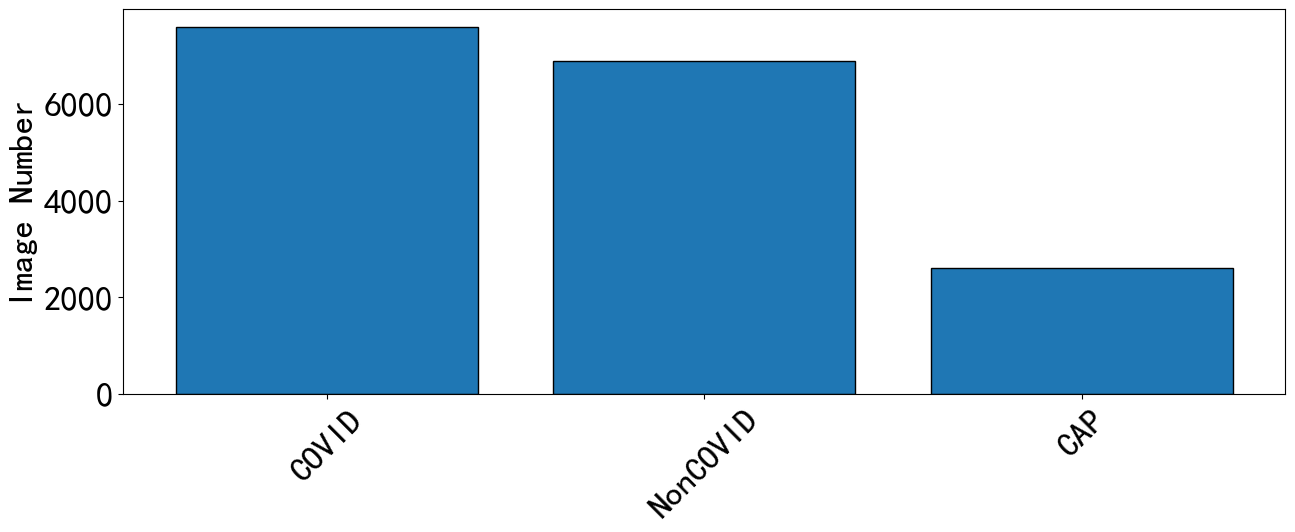

In [33]:
plt.figure(figsize = (15, 5))

x = df['class']
y = df[feature]

plt.bar(x, y, facecolor = '#1f77b4', edgecolor = 'k')
plt.xticks(rotation = 45)
plt.tick_params(labelsize = 25)
plt.ylabel('Image Number', fontsize = 25)
plt.savefig('figure/Image Number.tif', dpi = 300, bbox_inches = 'tight')

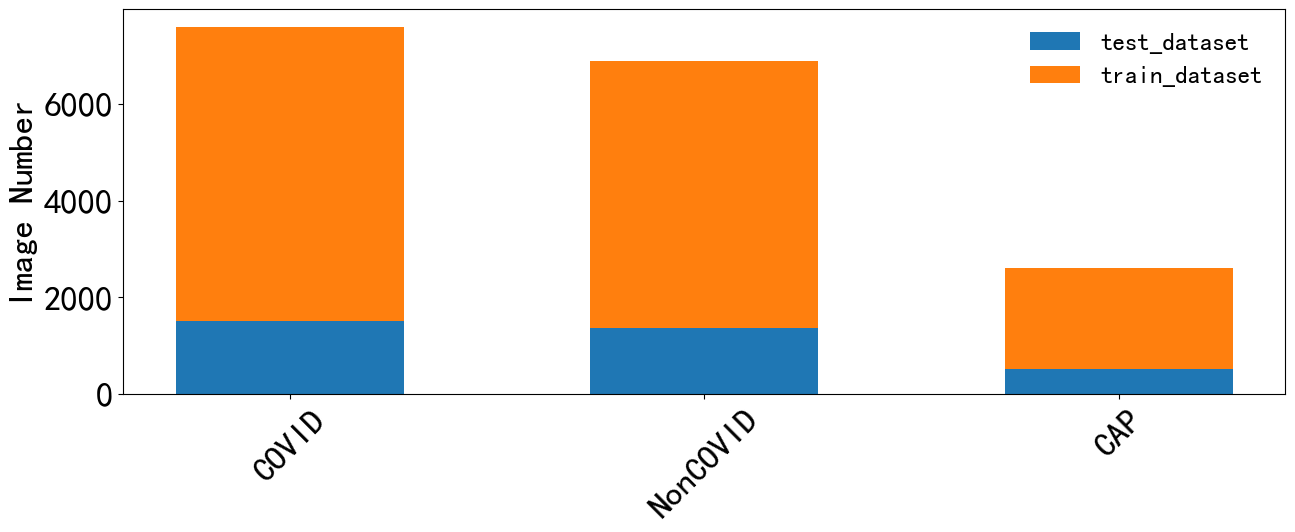

In [34]:
plt.figure(figsize = (15, 5))
x = df['class']
y1 = df['testset']
y2 = df['trainset']

width = 0.55 

plt.xticks(rotation = 45,fontsize = 25) 
plt.bar(x, y1, width, label = 'test_dataset')
plt.bar(x, y2, width, label = 'train_dataset', bottom = y1)

plt.ylabel('Image Number', fontsize = 25)
plt.tick_params(labelsize = 25) 
plt.legend(fontsize = 18, frameon = False)
plt.savefig('figure/Image Number_split.tif', dpi = 300, bbox_inches = 'tight')